<a href="https://colab.research.google.com/github/NUELBUNDI/PDS_PROJECT/blob/main/PDS_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PRINCIPLES OF DATA SCIENCE MODULE PROJECT:**
1.   **Student Name    : LEE BUND1**
2.   **Student No      : 102586**









In [31]:
%matplotlib inline
from bokeh.io import output_notebook
from bokeh import models, palettes, transform
from bokeh.plotting import figure, show
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import cluster, decomposition, pipeline, preprocessing
import statsmodels
import missingno as mn
import plotly.offline as pyo
import plotly.express as px
import plotly.graph_objects as go


In [32]:
# Read csv File.

df= pd.read_csv("https://raw.githubusercontent.com/NUELBUNDI/PDS_PROJECT/main/Salesdata.csv",encoding="Latin-1")

# **SECTION 1 : CLEANING DATA**

In [33]:
# read first five rows
df.head(2)

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,PRODUCTLINE,MSRP,PRODUCTCODE,CUSTOMERNAME,PHONE,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,$95.70,2,"$2,871.00",2/24/2003 0:00,Shipped,1,Motorcycles,95,S10_1678,Land of Toys Inc.,2125557818,897 Long Airport Avenue,NaN,NYC,NY,10022,USA,NaN,Yu,Kwai,Small
1,10121,34,$81.35,5,"$2,765.90",05-07-03 0:00,Shipped,2,Motorcycles,95,S10_1678,Reims Collectables,26.47.1555,59 rue de l'Abbaye,NaN,Reims,NaN,51100,France,EMEA,Henriot,Paul,Small


In [34]:
# Convert the Columns to lower case and Remove spaces  Ease with uniform case.
df.columns=df.columns.str.lower()
df.columns=df.columns.str.replace(' ','')
df.columns

Index(['ordernumber', 'quantityordered', 'priceeach', 'orderlinenumber',
       'sales', 'orderdate', 'status', 'qtr_id', 'productline', 'msrp',
       'productcode', 'customername', 'phone', 'addressline1', 'addressline2',
       'city', 'state', 'postalcode', 'country', 'territory',
       'contactlastname', 'contactfirstname', 'dealsize'],
      dtype='object')

In [48]:
# Remove $ and ,

# Create a function 
def convert(x):
  if isinstance(x, str):
    return(x.replace('$', '').replace(',', ''))
  return(x)
  
# Apply the function.

df['priceeach']=df['priceeach'].apply(lambda x: convert(x)).astype(float)
df['sales']=df['sales'].apply(lambda x: convert(x)).astype(float)
df.head(3)


,ordernumber,quantityordered,priceeach,orderlinenumber,sales,orderdate,ordermonth,orderyear,status,qtr_id,productline,msrp,productcode,customername,phone,addressline1,city,state,postalcode,country,contactlastname,contactfirstname,dealsize,quarters
0,10107,30,95.70,2,2871.00,2003-02-24,2,2003,Shipped,1,Motorcycles,95,S10_1678,Land of Toys Inc.,2125557818,897 Long Airport Avenue,NYC,NY,10022,USA,Yu,Kwai,Small,Q1
1,10121,34,81.35,5,2765.90,2003-05-07,5,2003,Shipped,2,Motorcycles,95,S10_1678,Reims Collectables,26.47.1555,59 rue de l'Abbaye,Reims,NaN,51100,France,Henriot,Paul,Small,Q2
2,10134,41,94.74,2,3884.34,2003-07-01,7,2003,Shipped,3,Motorcycles,95,S10_1678,Lyon Souveniers,+33 1 46 62 7555,27 rue du Colonel Pierre Avia,Paris,NaN,75508,France,Da Cunha,Daniel,Medium,Q3


In [49]:
# convert order date to pd date time frame and  create a  new month and year colum

df['orderdate']=pd.to_datetime(df['orderdate'])
df['ordermonth']=df['orderdate'].dt.month
df['orderyear']=df['orderdate'].dt.year

df.head(2)


,ordernumber,quantityordered,priceeach,orderlinenumber,sales,orderdate,ordermonth,orderyear,status,qtr_id,productline,msrp,productcode,customername,phone,addressline1,city,state,postalcode,country,contactlastname,contactfirstname,dealsize,quarters
0,10107,30,95.70,2,2871.0,2003-02-24,2,2003,Shipped,1,Motorcycles,95,S10_1678,Land of Toys Inc.,2125557818,897 Long Airport Avenue,NYC,NY,10022,USA,Yu,Kwai,Small,Q1
1,10121,34,81.35,5,2765.9,2003-05-07,5,2003,Shipped,2,Motorcycles,95,S10_1678,Reims Collectables,26.47.1555,59 rue de l'Abbaye,Reims,NaN,51100,France,Henriot,Paul,Small,Q2


In [50]:
# Arrange dataframe columns

cols=list(df.columns.values)

df=df[['ordernumber', 'quantityordered','priceeach', 'orderlinenumber', 'sales', 'orderdate','ordermonth','orderyear','status', 'qtr_id', 'productline', 'msrp', 'productcode', 'customername','phone', 'addressline1', 'city', 'state', 'postalcode', 'country', 'contactlastname', 'contactfirstname', 'dealsize']]


In [51]:
df['quarters']=df['ordermonth'].apply(lambda x :'Q1' if x<=3 else('Q2' if (x>3 and x<=6) else ('Q3' if (x>6 and x<=8) else 'Q4')))
df.head(4)

,ordernumber,quantityordered,priceeach,orderlinenumber,sales,orderdate,ordermonth,orderyear,status,qtr_id,productline,msrp,productcode,customername,phone,addressline1,city,state,postalcode,country,contactlastname,contactfirstname,dealsize,quarters
0,10107,30,95.70,2,2871.00,2003-02-24,2,2003,Shipped,1,Motorcycles,95,S10_1678,Land of Toys Inc.,2125557818,897 Long Airport Avenue,NYC,NY,10022,USA,Yu,Kwai,Small,Q1
1,10121,34,81.35,5,2765.90,2003-05-07,5,2003,Shipped,2,Motorcycles,95,S10_1678,Reims Collectables,26.47.1555,59 rue de l'Abbaye,Reims,NaN,51100,France,Henriot,Paul,Small,Q2
2,10134,41,94.74,2,3884.34,2003-07-01,7,2003,Shipped,3,Motorcycles,95,S10_1678,Lyon Souveniers,+33 1 46 62 7555,27 rue du Colonel Pierre Avia,Paris,NaN,75508,France,Da Cunha,Daniel,Medium,Q3
3,10145,45,83.26,6,3746.70,2003-08-25,8,2003,Shipped,3,Motorcycles,95,S10_1678,Toys4GrownUps.com,6265557265,78934 Hillside Dr.,Pasadena,CA,90003,USA,Young,Julie,Medium,Q3


In [52]:
print(f' The Shape of the Dataframe is in Rows and Columns respectively as  {df.shape}')

 The Shape of the Dataframe is in Rows and Columns respectively as  (2823, 24)


In [53]:
# Check for the Missing Values as value of Mean Percentage per rows so as to evaluate their relevance 

d_types=df.dtypes
d_missing=df.isnull().mean().round(4)*100

# converting to data frames

details1=pd.DataFrame(d_types,columns=['DTYPE'])
details2=pd.DataFrame(d_missing,columns=['MISSING'])

# Combine the dataframes
combine_df=pd.concat([details1,details2],axis=1)
combine_df.sort_values(by='MISSING',ascending=False)


,DTYPE,MISSING
state,object,52.64
postalcode,object,2.69
ordernumber,int64,0.00
quantityordered,int64,0.00
dealsize,object,0.00
contactfirstname,object,0.00
contactlastname,object,0.00
country,object,0.00
city,object,0.00
addressline1,object,0.00


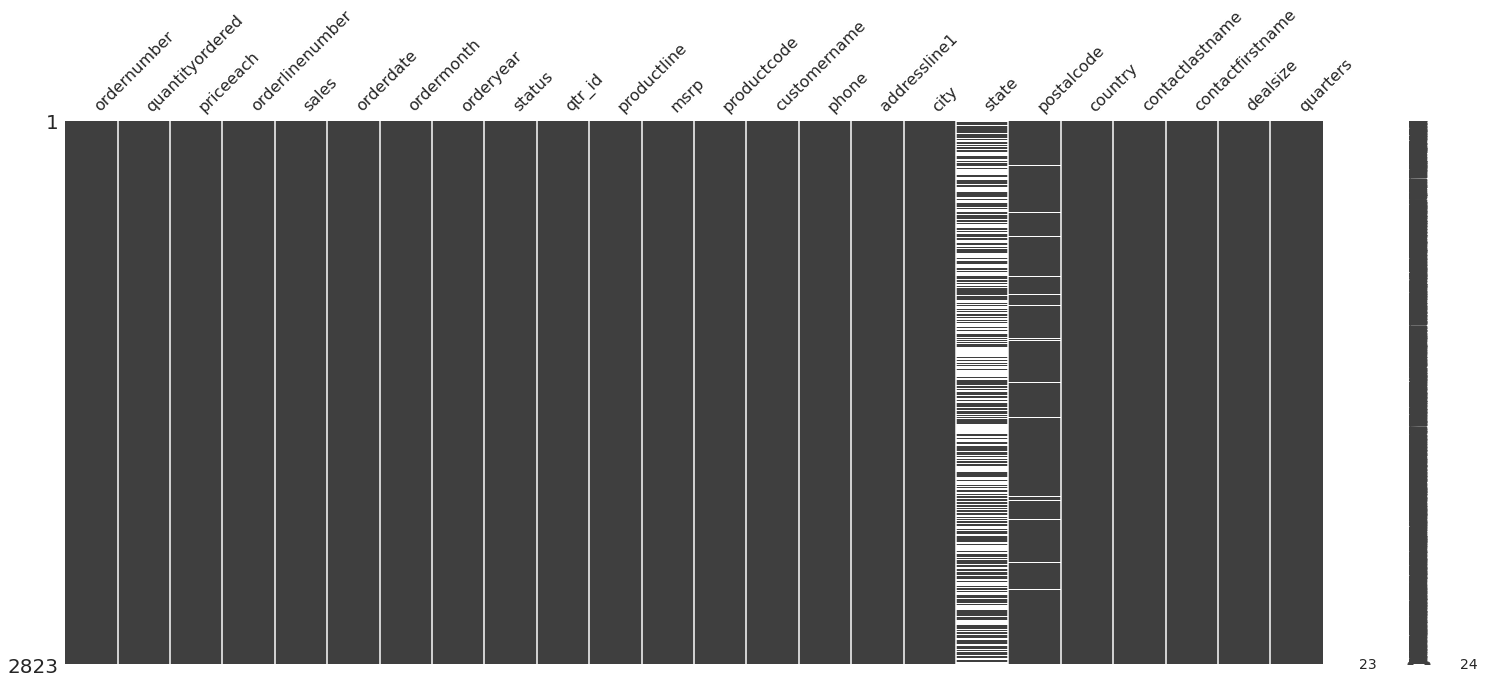

In [54]:
#Visualize the missing values

mn.matrix(df)

In [55]:
# Check for duplicates

df.duplicated( keep='first').sum()

0

# **SECTION 2:** **EXPLORATORY DATA ANALYSIS**

In [56]:
df.describe()

,ordernumber,quantityordered,priceeach,orderlinenumber,sales,ordermonth,orderyear,qtr_id,msrp
count,2823.000000,2823.000000,2823.000000,2823.000000,2823.000000,2823.000000,2823.00000,2823.000000,2823.000000
mean,10258.725115,35.092809,83.658544,6.466171,3553.889072,7.092455,2003.81509,2.717676,100.715551
std,92.085478,9.741443,20.174277,4.225841,1841.865106,3.656633,0.69967,1.203878,40.187912
min,10100.000000,6.000000,26.880000,1.000000,482.130000,1.000000,2003.00000,1.000000,33.000000
25%,10180.000000,27.000000,68.860000,3.000000,2203.430000,4.000000,2003.00000,2.000000,68.000000
50%,10262.000000,35.000000,95.700000,6.000000,3184.800000,8.000000,2004.00000,3.000000,99.000000
75%,10333.500000,43.000000,100.000000,9.000000,4508.000000,11.000000,2004.00000,4.000000,124.000000
max,10425.000000,97.000000,100.000000,18.000000,14082.800000,12.000000,2005.00000,4.000000,214.000000


In [57]:
# Check How Many Unique Values we have in the Data

for col in df.columns:
  # print(col)
  print(f'The Unique values in {col} are  {df[col].nunique()}')

The Unique values in ordernumber are  307
The Unique values in quantityordered are  58
The Unique values in priceeach are  1016
The Unique values in orderlinenumber are  18
The Unique values in sales are  2763
The Unique values in orderdate are  252
The Unique values in ordermonth are  12
The Unique values in orderyear are  3
The Unique values in status are  6
The Unique values in qtr_id are  4
The Unique values in productline are  7
The Unique values in msrp are  80
The Unique values in productcode are  109
The Unique values in customername are  92
The Unique values in phone are  91
The Unique values in addressline1 are  92
The Unique values in city are  73
The Unique values in state are  16
The Unique values in postalcode are  73
The Unique values in country are  19
The Unique values in contactlastname are  77
The Unique values in contactfirstname are  72
The Unique values in dealsize are  3
The Unique values in quarters are  4


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



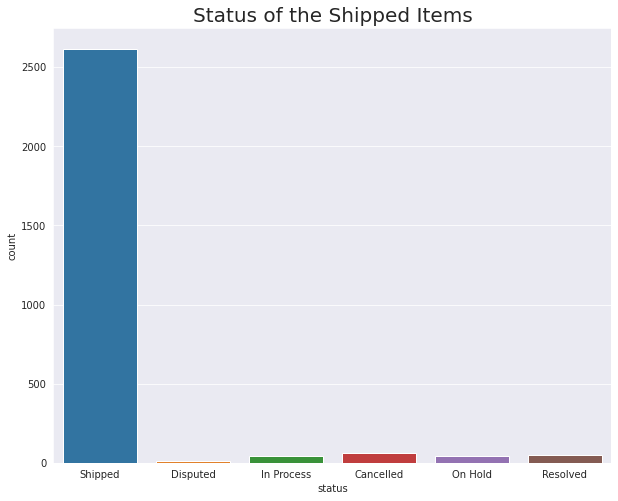

In [58]:
plt.figure(figsize=(10,8))
sns.countplot(df['status'],label="Count")
plt.title('Status of the Shipped Items',fontsize=20)
plt.show()   

In [59]:
table=pd.pivot_table(df,index='status',aggfunc={'sales':np.sum}).reset_index()

table

,status,sales
0,Cancelled,194487.48
1,Disputed,72212.86
2,In Process,144729.96
3,On Hold,178979.19
4,Resolved,150718.28
5,Shipped,9291501.08


In [18]:
# co=df['status'].value_counts()
# co.values

In [60]:
# Drop all the Cancelled and Disputed order in our Data Frame.

cols=['Cancelled','Disputed']

for col in cols:
  df.drop(df[df['status']==col].index,inplace=True)

df['status'].unique()

array(['Shipped', 'In Process', 'On Hold', 'Resolved'], dtype=object)

In [61]:
df.head(2)

,ordernumber,quantityordered,priceeach,orderlinenumber,sales,orderdate,ordermonth,orderyear,status,qtr_id,productline,msrp,productcode,customername,phone,addressline1,city,state,postalcode,country,contactlastname,contactfirstname,dealsize,quarters
0,10107,30,95.70,2,2871.0,2003-02-24,2,2003,Shipped,1,Motorcycles,95,S10_1678,Land of Toys Inc.,2125557818,897 Long Airport Avenue,NYC,NY,10022,USA,Yu,Kwai,Small,Q1
1,10121,34,81.35,5,2765.9,2003-05-07,5,2003,Shipped,2,Motorcycles,95,S10_1678,Reims Collectables,26.47.1555,59 rue de l'Abbaye,Reims,NaN,51100,France,Henriot,Paul,Small,Q2


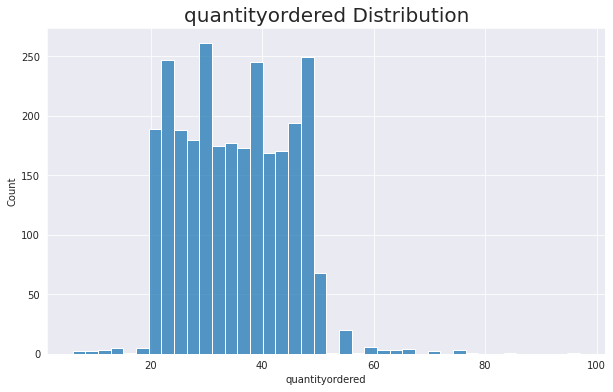

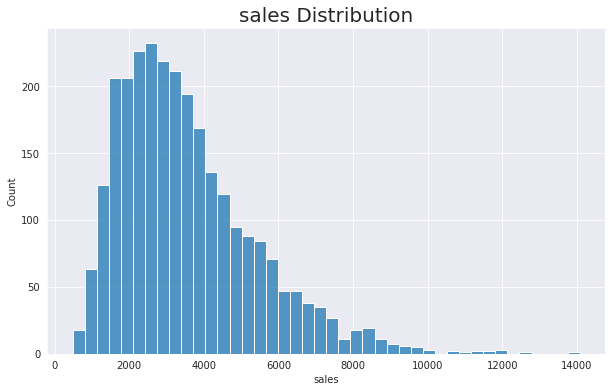

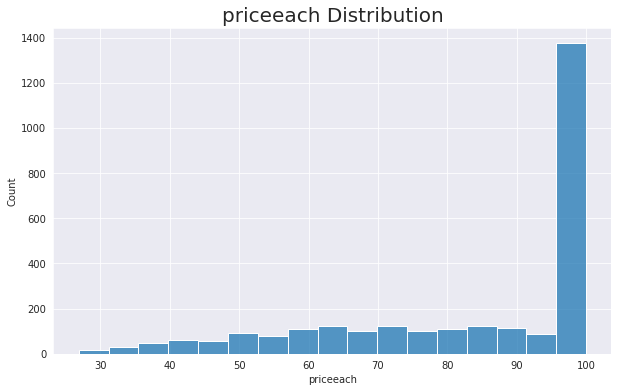

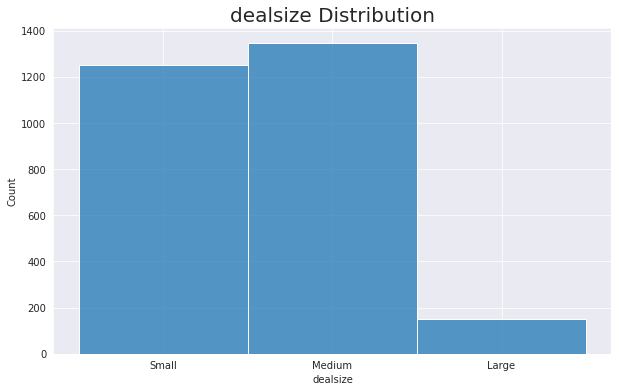

In [62]:
# Ploting  Distribution

variable=['quantityordered','sales','priceeach','dealsize']
for var in variable:
  plt.figure(figsize=(10,6))
  sns.set_style('darkgrid')
  sns.histplot(df[var])
  plt.title(f'{var} Distribution',fontsize= 20)
  plt.xlabel(f'{var}')
  plt.ylabel('Count')
  plt.show()

   

From the above Histo plots.

1.   We see that majority of the orders range from 20 to  50 units--> we can infere majority of the orders are bulker.
2.   The Majority of orders are for price $100.

1.   The Sales are skwed to the Left.
2.   The Medium Dealsize is highest No. of frequency in the distribution.










In [63]:
df.head(2)

,ordernumber,quantityordered,priceeach,orderlinenumber,sales,orderdate,ordermonth,orderyear,status,qtr_id,productline,msrp,productcode,customername,phone,addressline1,city,state,postalcode,country,contactlastname,contactfirstname,dealsize,quarters
0,10107,30,95.70,2,2871.0,2003-02-24,2,2003,Shipped,1,Motorcycles,95,S10_1678,Land of Toys Inc.,2125557818,897 Long Airport Avenue,NYC,NY,10022,USA,Yu,Kwai,Small,Q1
1,10121,34,81.35,5,2765.9,2003-05-07,5,2003,Shipped,2,Motorcycles,95,S10_1678,Reims Collectables,26.47.1555,59 rue de l'Abbaye,Reims,NaN,51100,France,Henriot,Paul,Small,Q2


In [64]:
# Compare Sales  and the Quantity Order.

sales_quantity=df.groupby('productline')[['quantityordered','sales']].sum().reset_index()
sales_quantity

,productline,quantityordered,sales
0,Classic Cars,33325,3834359.98
1,Motorcycles,11404,1134566.44
2,Planes,10249,935727.02
3,Ships,7467,654701.08
4,Trains,2670,221161.05
5,Trucks and Buses,10777,1127789.84
6,Vintage Cars,20540,1857623.10


In [127]:
customdata=sales_quantity[['productline','quantityordered','sales']]


In [137]:
bar_data1 = go.Bar(
          x = sales_quantity['productline'],
          y = sales_quantity['quantityordered'],
          name = 'quantityordered',
          text = sales_quantity['quantityordered'],
          texttemplate = '%{text:.2s}',
          textposition = 'inside',
          yaxis = 'y1',
          offsetgroup=1,
          marker=dict(color=' #7F8C8D'),
          customdata=sales_quantity[['productline','quantityordered','sales']],
          hovertemplate =
          '<br><b>Product</b>: %{customdata[0]}<br><extra></extra>'+
          '<b>ordered</b>: %{customdata[1]:,.0f}'
          )

bar_data2 = go.Bar(
          x = sales_quantity['productline'],
          y = sales_quantity['sales'],
          name = 'Sales',
          text = sales_quantity['sales'],
          texttemplate = '%{text:.2s}',
          textposition = 'auto',
          yaxis = 'y2',
          offsetgroup=2,
          marker=dict(color='#B45513'),
          customdata=sales_quantity[['productline','quantityordered','sales']],
          hovertemplate =
          '<br><b>Product</b>: %{customdata[0]}<br><extra></extra>'+
          '<b>Total Sales</b>: %{customdata[2]:,.0f}'
          )

data = [bar_data1, bar_data2]

layout = go.Layout(title={'text': 'Sales of ordered Quantity',
                          'y': 0.93,
                          'x': 0.5,
                          'xanchor': 'center',
                          'yanchor': 'top'},
                   titlefont={'family': 'Oswald', 
                              'color': 'rgb(230, 34, 144)',
                              'size': 25},
                              hovermode='x',
                              height=550,
                     xaxis=dict(title='<b>Name of the Product</b>',
                            tick0=0,
                            dtick=1,
                            color='rgb(230, 34, 144)',
                            showline=True,
                            showgrid=True,
                            showticklabels=True,
                            linecolor='rgb(104, 204, 104)',
                            linewidth=2,
                            ticks='outside',
                            tickfont=dict(family='Arial',
                                size=12,
                                color='rgb(17, 37, 239)')
                            ),

                    yaxis=dict(title='<b>Quantity Ordered</b>',
                        color='rgb(230, 34, 144)',
                        showline=True,
                        showgrid=True,
                        showticklabels=True,
                        linecolor='rgb(104, 204, 104)',
                        linewidth=2,
                        ticks='outside',
                        tickfont=dict(family='Arial',
                            size=12,
                            color='rgb(17, 37, 239)')
                        
                        ),
                 yaxis2=dict(title='<b>sales</b>', 
                             overlaying='y', side='right',
                             color='rgb(230, 34, 144)',
                             showline=True,
                             showgrid=False,
                             showticklabels=True,
                            linecolor='rgb(104, 204, 104)',
                            linewidth=2,
                            ticks='outside',
                            tickfont=dict(family='Arial',
                                         size=12,
                                        color='rgb(17, 37, 239)') 
                            )
)

            
figure=go.Figure(data=data, layout=layout)

figure.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



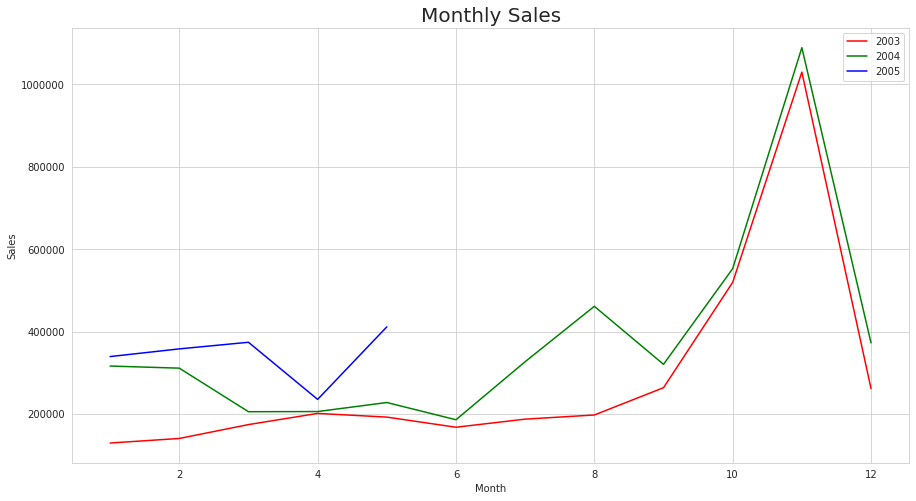

In [66]:
# Sales Trend Per Month
sales_trend=df.groupby(['ordermonth','orderyear']).agg({'sales':np.sum})
sales_trend=sales_trend.reset_index()
sales_trend.columns=['month','year','sale']


# plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')
plt.figure(figsize=(15,8))
lp=sns.lineplot('month','sale',hue='year',data=sales_trend,palette=["r",'g','b'])
lp.legend(loc='upper right')
plt.title('Monthly Sales',fontsize=20)
plt.xlabel('Month')
plt.ticklabel_format(style='plain')
plt.ylabel('Sales')
plt.show()

In [69]:
salesgrowth=sales_trend.sort_values(['year','month'],ascending=True)
salesgrowth.reset_index(drop=True,inplace=True)
salesgrowth['growthrate']=salesgrowth['sale'].pct_change()
salesgrowth



,month,year,sale,growthrate
0,1,2003,129753.60,NaN
1,2,2003,140836.19,0.085413
2,3,2003,174504.90,0.239063
3,4,2003,201609.55,0.155323
4,5,2003,192673.11,-0.044325
5,6,2003,168082.56,-0.127628
6,7,2003,187731.88,0.116903
7,8,2003,197809.30,0.053680
8,9,2003,263973.36,0.334484
9,10,2003,519580.05,0.968305


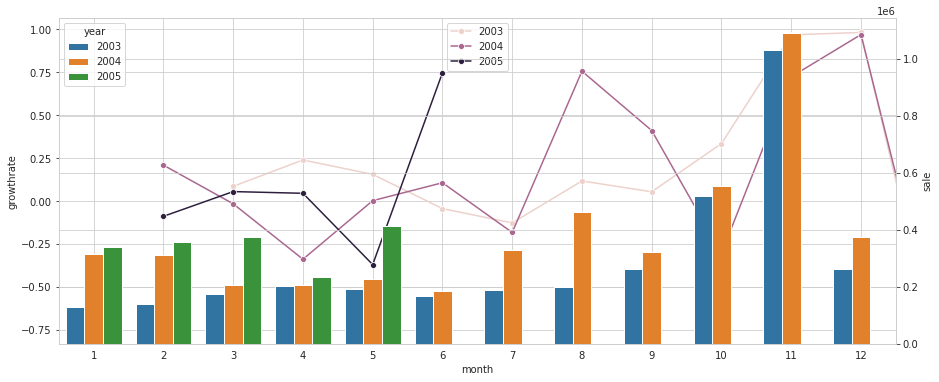

In [68]:
fig, ax = plt.subplots(figsize=(15,6))
sns.lineplot(x='month',y='growthrate',marker='o',hue='year',ax=ax,data=salesgrowth)
ax.legend(['2003', '2004', '2005'],loc='upper center')
ax1=ax.twinx()
sns.barplot(x='month',y='sale',data=salesgrowth,ax=ax1,hue='year')
# plt.ticklabel_format(style='plain')

In [75]:
# calculate year Sales


sales_per_year=df.groupby('orderyear')[['sales','quantityordered']].sum().reset_index()
sales_per_year

,orderyear,sales,quantityordered
0,2003,3468268.62,34062
1,2004,4578386.04,45336
2,2005,1719273.85,17034


In [109]:
bar_data1 = go.Bar(
          x = sales_per_year['orderyear'],
          y = sales_per_year['sales'],
          name = 'Sales',
          text = sales_per_year['sales'],
          texttemplate = '%{text:.2s}',
          textposition = 'inside',
          yaxis = 'y1',
          marker=dict(color=' #7F8C8D'),
          customdata=sales_per_year[['orderyear', 'sales', 'quantityordered']],
          hovertemplate =
          '<br><b>Year</b>: %{customdata[0]}<br><extra></extra>'+
          '<b>Sales</b>: $%{customdata[1]:,.0f}'
          )

line_data2 = go.Scatter(
          x = sales_per_year['orderyear'],
          y = sales_per_year['quantityordered'],
          name = 'Quantity Ordered',
          text = sales_per_year['quantityordered'],
          mode = 'markers + lines',
          yaxis = 'y2',
          marker=dict(color='#DC7633 '),
          customdata=sales_per_year[['orderyear', 'sales', 'quantityordered']],
          hovertemplate =
          '<br><b>Year</b>: %{customdata[0]}<br><extra></extra>'+
          '<b>Quantity Ordered</b>: %{customdata[2]:,.0f}'
          )

data = [bar_data1, line_data2]

layout = go.Layout(title={
                         'text': 'Yearly Sales and Quantity Ordered',
                          'y': 0.93,
                          'x': 0.5,
                          'xanchor': 'center',
                          'yanchor': 'top'},
                   titlefont={'family': 'Oswald', 
                              'color': 'rgb(230, 34, 144)',
                              'size': 25},
                              hovermode='x',
                              height=550,
                     xaxis=dict(title='<b>Year</b>',
                            tick0=0,
                            dtick=1,
                            color='rgb(230, 34, 144)',
                            showline=True,
                            showgrid=True,
                            showticklabels=True,
                            linecolor='rgb(104, 204, 104)',
                            linewidth=2,
                            ticks='outside',
                            tickfont=dict(family='Arial',
                                size=12,
                                color='rgb(17, 37, 239)')
                            ),

                    yaxis=dict(title='<b>Total Sales </b>',
                        color='rgb(230, 34, 144)',
                        showline=True,
                        showgrid=True,
                        showticklabels=True,
                        linecolor='rgb(104, 204, 104)',
                        linewidth=2,
                        ticks='outside',
                        tickfont=dict(family='Arial',
                            size=12,
                            color='rgb(17, 37, 239)')
                        
                        ),
                 yaxis2=dict(title='<b>Total Quantity Ordered</b>', 
                             overlaying='y', side='right',
                             color='rgb(230, 34, 144)',
                             showline=True,
                             showgrid=False,
                             showticklabels=True,
                            linecolor='rgb(104, 204, 104)',
                            linewidth=2,
                            ticks='outside',
                            tickfont=dict(family='Arial',
                                         size=12,
                                        color='rgb(17, 37, 239)') 
                            )
)

            
figure=go.Figure(data=data, layout=layout)

figure.show()

In [152]:
# Average Sales Each Month.


average_sales_per_month=df.groupby(['orderyear','ordermonth']).agg({'sales':np.mean}).reset_index()
average_sales_per_month


,orderyear,ordermonth,sales
0,2003,1,3327.015385
1,2003,2,3435.029024
2,2003,3,3490.098000
3,2003,4,3476.026724
4,2003,5,3321.950172
5,2003,6,3653.968696
6,2003,7,3754.637600
7,2003,8,3410.505172
8,2003,9,3473.333684
9,2003,10,3659.014437


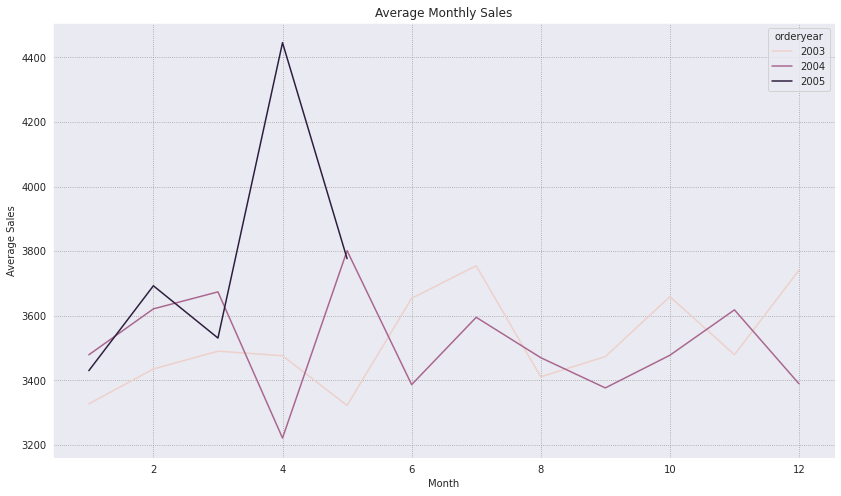

In [162]:
plt.figure(figsize=(14,8))
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
sns.lineplot(x='ordermonth',y='sales',data=average_sales_per_month,hue='orderyear')
plt.title('Average Monthly Sales')
plt.xlabel('Month')
plt.ylabel('Average Sales')
plt.show()

In [ ]:
# sales  Per  Quarters

**SECTION 2B.  
CUSTOMER ANALYSIS**

In [ ]:
# Calculate the Top 20 Countries

sales_per_country=df.groupby('')

In [ ]:
# Calculate Sales Per  City.

In [ ]:
# Frequency of  Specific Customer Per Year  / Active Customer

In [ ]:
# Compare Sales of each Country on Scatter Plot

In [ ]:
# Compare Sales of Country on Bubble Chart

In [ ]:
# 

In [164]:
df.head()

,ordernumber,quantityordered,priceeach,orderlinenumber,sales,orderdate,ordermonth,orderyear,status,qtr_id,productline,msrp,productcode,customername,phone,addressline1,city,state,postalcode,country,contactlastname,contactfirstname,dealsize,quarters
0,10107,30,95.70,2,2871.00,2003-02-24,2,2003,Shipped,1,Motorcycles,95,S10_1678,Land of Toys Inc.,2125557818,897 Long Airport Avenue,NYC,NY,10022,USA,Yu,Kwai,Small,Q1
1,10121,34,81.35,5,2765.90,2003-05-07,5,2003,Shipped,2,Motorcycles,95,S10_1678,Reims Collectables,26.47.1555,59 rue de l'Abbaye,Reims,NaN,51100,France,Henriot,Paul,Small,Q2
2,10134,41,94.74,2,3884.34,2003-07-01,7,2003,Shipped,3,Motorcycles,95,S10_1678,Lyon Souveniers,+33 1 46 62 7555,27 rue du Colonel Pierre Avia,Paris,NaN,75508,France,Da Cunha,Daniel,Medium,Q3
3,10145,45,83.26,6,3746.70,2003-08-25,8,2003,Shipped,3,Motorcycles,95,S10_1678,Toys4GrownUps.com,6265557265,78934 Hillside Dr.,Pasadena,CA,90003,USA,Young,Julie,Medium,Q3
4,10159,49,100.00,14,5205.27,2003-10-10,10,2003,Shipped,4,Motorcycles,95,S10_1678,Corporate Gift Ideas Co.,6505551386,7734 Strong St.,San Francisco,CA,NaN,USA,Brown,Julie,Medium,Q4


# **SECTION 3. MACHINE LEARNING MODELS**

1.   Time Series Analysis.
2.   Clustering-Unsupervised Machine Learning.



# **SECTION 4. PRESENTATION AND REPORTING**